# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.944377,False,-1.058411
1,-0.226095,True,3.999184
2,-2.363965,False,-1.388672
3,-1.340643,False,-1.319006
4,-1.188821,False,-1.994718
...,...,...,...
995,-0.009112,True,3.958634
996,-1.669372,True,5.810738
997,-0.196890,True,4.757233
998,-2.442120,False,-2.176536


<AxesSubplot: xlabel='v0'>

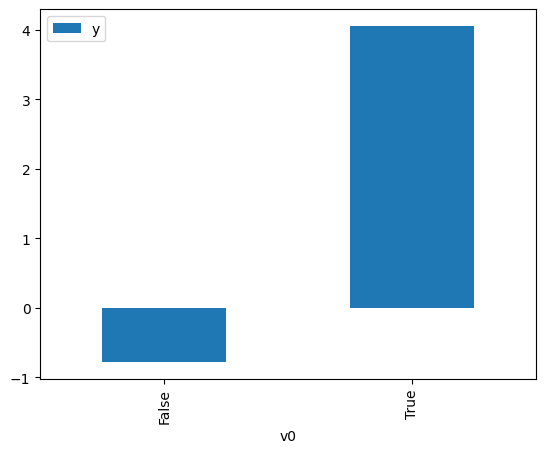

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

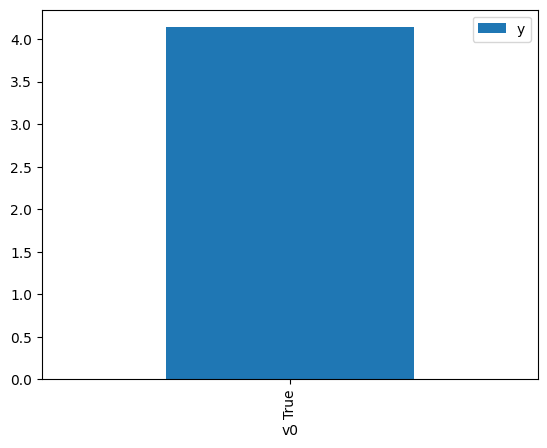

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.030907,False,0.653785,0.474155,2.109014
1,-0.353377,False,-1.038776,0.518313,1.929336
2,0.055643,False,-0.503726,0.462343,2.162894
3,-1.254629,False,-1.673596,0.638138,1.567060
4,-0.118293,False,0.303329,0.486110,2.057146
...,...,...,...,...,...
995,-0.364394,False,-1.463887,0.519821,1.923741
996,-1.135074,False,-0.132431,0.622872,1.605465
997,-2.370753,False,-0.236214,0.764781,1.307563
998,-1.166201,False,-0.896010,0.626872,1.595222


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.624025,True,2.115097,0.316529,3.159266
1,-0.360570,True,5.672464,0.480703,2.080288
2,-0.862055,True,2.636511,0.412871,2.422062
3,-0.709497,True,4.102400,0.433279,2.307982
4,-3.217392,True,1.081379,0.162038,6.171404
...,...,...,...,...,...
995,-1.153740,True,5.597034,0.374727,2.668608
996,-1.817651,True,3.567567,0.294028,3.401038
997,-1.148774,True,3.592059,0.375365,2.664072
998,-0.101798,True,3.762000,0.516148,1.937430


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                              5037.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):                        0.00
Time:                        14:46:50   Log-Likelihood:                         -1403.7
No. Observations:                1000   AIC:                                      2811.
Df Residuals:                     998   BIC:                                      2821.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9559      0.025     37.875      0.000       0.906       1.005
x2             4.9835      0.050     99.797      0.000       4.886       5.082
==============================================================================
Omnibus:                        1.048   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.592   Jarque-Bera (JB):                1.117
Skew:                           0.047   Prob(JB):                        0.572
Kurtosis:                       2.866   Cond. No.                         2.11
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""